In [1]:
import torch.nn   as nn
import GM_library as GML
import numpy      as np
import torch
import json

from os                   import path, listdir
from torch_geometric.data import Data

import sys
sys.path.append('../')
import MP.MP_library as MPL

# Checking if pytorch can run in GPU, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# Read the file in JSON format to a dictionary
with open('model_parameters.json', 'r') as json_file:
    model_parameters = json.load(json_file)

# Number of graphs to predict
N_predictions = 10

# Number of diffusing and denoising steps
n_t_steps = model_parameters['n_t_steps']

# Decay of parameter alpha
noise_contribution = model_parameters['noise_contribution']
alpha_decay = 0.5 * (1 - noise_contribution**2)

# Dropouts for node and edge models (independent of each other)
dropout_node = model_parameters['dropout_node']
dropout_edge = model_parameters['dropout_edge']

# Define box shape
L = model_parameters['L']

# Target to generate new crystals
target = 'GM_EPA'

# In case database is created from scratch (otherwise, it is not being used)
DB_path = '../MP/Loaded_EMP'

input_folder    = 'models'
target_folder   = f'{input_folder}/{target}'
edge_model_name = f'{target_folder}/edge_model.pt'
node_model_name = f'{target_folder}/node_model.pt'

In [3]:
# Number of graphs to predict
N_predictions = 10

# Number of diffusing and denoising steps, which can be different
n_denoising_steps = 2

# Dropouts for node and edge models (independent of each other)
dropout_node = 0.2
dropout_edge = 0.2

# Define box shape
L = [20, 20, 20]

# Target to generate new crystals
target = 'GM_EPA'

# In case database is created from scratch (otherwise, it is not being used)
DB_path = '../MP/Loaded_EMP'

input_folder    = 'models'
target_folder   = f'{input_folder}/{target}'
edge_model_name = f'{target_folder}/edge_model.pt'
node_model_name = f'{target_folder}/node_model.pt'

# Generation of graph database for training

Load the datasets, already standarized if possible.

In [4]:
labels_name         = f'{target_folder}/labels.pt'
dataset_name        = f'{target_folder}/dataset.pt'
dataset_name_std    = f'{target_folder}/standardized_dataset.pt'
parameters_name_std = f'{target_folder}/standardized_parameters.pt'  # Parameters for rescaling the predictions

# Load the standardized dataset, with corresponding labels and parameters
dataset    = torch.load(dataset_name_std)
parameters = torch.load(parameters_name_std)

# Assigning parameters accordingly
target_mean, feat_mean, edge_mean, target_std, edge_std, feat_std, scale = parameters

# Defining target factor
target_factor = target_std / scale

In [5]:
# Calculate the mean and standard deviation of the number of nodes
total_nodes = torch.tensor([data.num_nodes for data in dataset])
mean_nodes  = torch.mean(total_nodes.float()).item()
std_nodes   = torch.std(total_nodes.float()).item()

mean_nodes, std_nodes

(620.1802978515625, 163.6297149658203)

# Loading the model

In [6]:
# Determine number of features in dataset, considering the t_step information
n_features = dataset[0].num_node_features + 1

# Instantiate the models for nodes and edges
node_model = GML.nGCNN(n_features, dropout_node).to(device)
node_model.load_state_dict(torch.load(node_model_name))
node_model.eval()

edge_model = GML.eGCNN(n_features, dropout_edge).to(device)
edge_model.load_state_dict(torch.load(edge_model_name))
edge_model.eval()

print('\nNode GCNN:')
print(node_model)
print('\nEdge GCNN:')
print(edge_model)


Node GCNN:
nGCNN(
  (conv1): GraphConv(5, 256)
  (conv2): GraphConv(256, 256)
  (conv3): GraphConv(256, 5)
)

Edge GCNN:
eGCNN(
  (linear1): Linear(in_features=6, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=1, bias=True)
)


# Generating new cystals

In [7]:
# Predicting loop
predicted_dataset = []
with torch.no_grad():
    for i in range(N_predictions):
        # Get random number of nodes
        n_nodes = int(np.random.normal(mean_nodes, std_nodes))
        
        # Diffuse the graph with some noise
        diffused_graph = GML.get_random_graph(n_nodes, n_features-1)
        
        # Denoise the diffused graph
        #print(f'Denoising...')
        denoised_graph, _ = GML.denoise(diffused_graph, n_t_steps, node_model, edge_model,
                                        s=alpha_decay)
        
        # Append generated graph
        predicted_dataset.append(denoised_graph)

# Revert stardadization
denoised_graphs = GML.revert_standardize_dataset(predicted_dataset, parameters)
denoised_graphs

[Data(x=[994, 4], edge_index=[2, 493521], edge_attr=[493521]),
 Data(x=[698, 4], edge_index=[2, 243253], edge_attr=[243253]),
 Data(x=[565, 4], edge_index=[2, 159330], edge_attr=[159330]),
 Data(x=[556, 4], edge_index=[2, 154290], edge_attr=[154290]),
 Data(x=[333, 4], edge_index=[2, 55278], edge_attr=[55278]),
 Data(x=[547, 4], edge_index=[2, 149331], edge_attr=[149331]),
 Data(x=[803, 4], edge_index=[2, 322003], edge_attr=[322003]),
 Data(x=[716, 4], edge_index=[2, 255970], edge_attr=[255970]),
 Data(x=[466, 4], edge_index=[2, 108345], edge_attr=[108345]),
 Data(x=[742, 4], edge_index=[2, 274911], edge_attr=[274911])]

In [18]:
denoised_graphs[3].edge_attr[denoised_graphs[3].edge_attr <= 0] = 0.1

(array([4.1000e+01, 6.4000e+02, 4.7000e+03, 1.8430e+04, 4.0587e+04,
        4.8178e+04, 3.0776e+04, 9.4670e+03, 1.3760e+03, 9.5000e+01]),
 array([-8.382902  , -4.251014  , -0.11912613,  4.012762  ,  8.1446495 ,
        12.276538  , 16.408426  , 20.540314  , 24.672201  , 28.80409   ,
        32.935978  ], dtype=float32),
 <BarContainer object of 10 artists>)

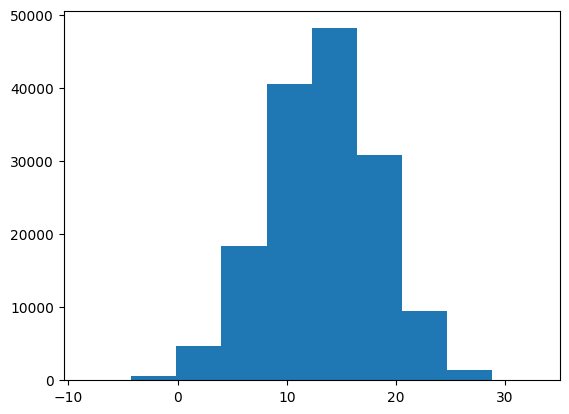

In [9]:
import matplotlib.pyplot as plt
plt.hist(denoised_graphs[3].edge_attr)

In [12]:
import importlib
importlib.reload(GML)

<module 'GM_library' from '/home/cibran.lopez/Work/UPC/GenerativeModels/GM_library.py'>

In [13]:
for i in range(N_predictions):
    graph = denoised_graphs[i].clone()
    try:
        GML.POSCAR_graph_encoding(graph, L, file_name=f'POSCAR-{i}', POSCAR_directory='./')
    except SystemExit:
        continue

Invalid graph, atoms overlapping. Applying brute force :)


/home/cibran.lopez/Work/UPC/GenerativeModels/GM_library.py:1048: RuntimeWarning: invalid value encountered in sqrt
  # Calculate the area using Heron's formula


0 2 20 20.472637 21.375732 24.352652 6.911644243319265 20.227484035969223
Invalid graph, atoms overlapping. Applying brute force :)
0 15 226 21.240791 21.421904 21.881697 10.151705583602915 18.863743743748447
Invalid graph, atoms overlapping. Applying brute force :)
0 22 32 27.321661 25.194637 19.201286 18.530233431650565 17.070448077766997
Invalid graph, atoms overlapping. Applying brute force :)
0 3 11 23.303768 20.546724 21.801765 10.5115299576348 17.65433709346101
Invalid graph, atoms overlapping. Applying brute force :)
0 7 99 20.832262 22.211594 21.532875 11.128732057403036 19.222544428009957
Invalid graph, atoms overlapping. Applying brute force :)
0 20 53 19.11492 23.781229 24.042595 9.230502759245686 21.916766925656145
Invalid graph, atoms overlapping. Applying brute force :)
0 8 52 27.041447 21.436113 19.829964 14.746240175178901 15.558128312024351
Invalid graph, atoms overlapping. Applying brute force :)
0 5 187 18.375935 24.990116 23.386774 11.298464106870245 22.29014608489

In [78]:
# Generate the raw dataset from scratch, and standardize it
L = [40, 40, 40]
path_to_POSCAR = '.'

# Extract parameters from POSCAR
cell, composition, concentration, positions = MPL.information_from_VASPfile(path_to_POSCAR,
                                                                            'POSCAR')

# Generate POSCAR covering the box
nodes, edges, attributes, all_nodes, all_positions, all_species = GML.graph_POSCAR_encoding(cell,
                                                              composition,
                                                              concentration,
                                                              positions,
                                                              L)

# Load ground state energy per atom
gs_energy = float(np.loadtxt(f'{path_to_POSCAR}/EPA'))

# Construct temporal graph structure
graph = Data(x=nodes,
             edge_index=edges,
             edge_attr=attributes,
             y=torch.tensor([[gs_energy]], dtype=torch.float)
            )
print(graph)
dataset.append(graph)

Data(x=[2413, 4], edge_index=[2, 2910078], edge_attr=[2910078], y=[1, 1])


In [85]:
composition, concentration, positions_sorted = GML.composition_concentration_from_keys(all_species,
                                                                                       np.array(all_positions))
np.savetxt('CONTCAR', positions_sorted)
composition, concentration

(['Ba', 'Na', 'Si'], [345, 715, 1353])

In [98]:
graph_0               = graph.clone()
graph_std, parameters = GML.standardize_dataset([graph_0])
graph_dstd            = GML.revert_standardize_dataset(graph_std, parameters)[0]

node_loss, edge_loss = GML.get_graph_losses(graph_0, graph_dstd)
node_loss, edge_loss

(tensor(0.), tensor(8.4791e-14))

In [114]:
import importlib
importlib.reload(GML)

<module 'GM_library' from '/Users/cibran/Work/UPC/GenerativeModels/GM_library.py'>

In [113]:
GML.POSCAR_graph_encoding(graph, L, POSCAR_name=None, POSCAR_directory='./')

/Users/cibran/Work/UPC/GenerativeModels/GM_library.py:1051: RuntimeWarning: invalid value encountered in sqrt
  # Calculate the area using Heron's formula


0 33 1492 40.763695 55.582813 51.303658 25.99203380784781 49.131082918601486


<_io.TextIOWrapper name='.//POSCAR' mode='w' encoding='UTF-8'>